In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib import dates as mdates
from datetime import datetime

In [227]:
df = pd.read_csv('./AH2023_Sylvania_1yr.csv')
df.head()

,Date time,Swdown,Lwdown,Rainf,Tair,Qair,Wind,Psurf,Ccov,Rnet,Qle,Qh,Qle (LSM),Qh (LSM)
0,2002/01/01 01:00,0.0,216.675,0.0,258.501,0.001170,2.588,94390.867,0.145,-29.267,0.833,-21.168,2.456,59.579
1,2002/01/01 01:30,0.0,216.936,0.0,258.576,0.001181,2.490,94392.797,0.132,-21.540,0.186,-13.835,1.922,46.012
2,2002/01/01 02:00,0.0,217.215,0.0,258.660,0.001192,2.320,94394.953,0.240,-22.932,0.296,-1.749,1.563,35.741
3,2002/01/01 02:30,0.0,218.276,0.0,258.992,0.001227,2.214,94403.469,0.211,-11.259,1.723,-12.495,1.247,26.644
4,2002/01/01 03:00,0.0,218.888,0.0,259.183,0.001247,2.344,94408.359,0.654,-28.586,1.821,-13.398,1.048,22.566


In [291]:
# define variables 
day_start = 48*90
day_end = 48*96
#days = 2*24*6
T = df['Tair'][day_start:day_end]
SH = df['Qair'][day_start:day_end]
WIND = df['Wind'][day_start:day_end]
PRES = df['Psurf'][day_start:day_end]
RN = df['Rnet'][day_start:day_end]
Sdown = df['Swdown'][day_start:day_end]
Ldown = df['Lwdown'][day_start:day_end]
Qle =df['Qle'][day_start:day_end]
Qh = df['Qh'][day_start:day_end]
date = [datetime.strptime(date_time,"%Y/%m/%d %H:%M") for date_time in df['Date time'][day_start:day_end]]

## define the equation

### deriverate

In [229]:
def derivarate(func,t,time):
    i = 1;a = 0;diff=1
    while abs(diff) > 1e-6:
        dt = 1/(10**i) 
        res = (func(t+dt,time) -func(t-dt,time))/(2*dt)
        diff = res -a
        a = res
        i+=1
    return res

### wind function

In [260]:
def wind_func(wind):
    return wind/1000

### latent heat flux

In [231]:
def QS(t,psurf):
    es = 6.11078 * 10 **(7.5*t/(t+237.3))
    res = 0.622 * (es/psurf)/(1-0.378*(es/psurf))
    return res

## the enegy balance function

In [271]:
#Ts:地表面温度 Ta:気温
def energy(temp,time):
    """
    ある時刻において，ある地表面温度を仮定したときのRnを返す＝地表面温度の関数
    """
    
    cp = 4.178 * 10**3 #J/（kg ･ K）
    l = 2.50 * 10 **6 #J/kg 
    sigma = 5.67 * 10 ** -8
    reflectance_l = 0.95
    Albedo = 0.93
    
    latent_heat = l * wind_func(WIND[time]) * (QS(temp-273.15,PRES[time]/100)-SH[time]) #セ氏に変換
    sensible_heat = cp * wind_func(WIND[time]) * (temp - T[time])
    ground_heat = 0 #assumption
    Lup = reflectance_l * sigma * temp**4 #+ (1-reflectance_l)*Ldown[time]
    
    res = Albedo * Sdown[time] + Ldown[time] - Lup -latent_heat - sensible_heat - ground_heat
    
    return res 
    
    

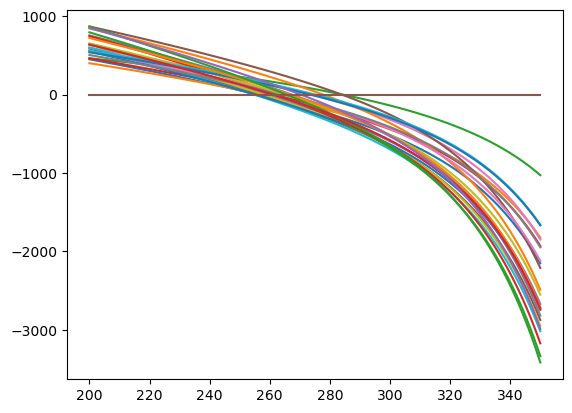

In [233]:
# check how the enegy function works
fig,ax = plt.subplots()
for time in np.linspace(0,264,25):
    temp = np.linspace(200,350,100)
    energy_return = [energy(tp,time) for tp in temp]
    ax.plot(temp,energy_return)
ax.plot(temp,np.linspace(0,0,100))

## 二分法による解の推定

In [289]:
def bisection_method(func, a, b, tol, max_iter,time):
    """
    二分法を用いて関数の解を求める

    Parameters:
        func (function): 解を求めたい関数
        a (float): 区間の下限
        b (float): 区間の上限
        tol (float): 許容誤差
        max_iter (int): 最大反復回数

    Returns:
        float: 解の近似値
    """
    if func(a,time) * func(b,time) >= 0:
        raise ValueError("関数の値が区間の両端で同符号です。二分法は使用できません。")

    for i in range(max_iter):
        c = (a + b) / 2
        if abs(func(c,time)) < tol:
            return c

        if func(a,time) * func(c,time) < 0:
            b = c
        else:
            a = c

    raise RuntimeError("解が見つかりませんでした。反復回数が上限に達しました。")


def bisection(min,max):
    Ts = np.zeros(len(date))
    for time in range(day_start,day_start+len(date)):
        #energy(temp,time)
        Ts[time-day_start] = bisection_method(energy, min, max, 1e-6, 50,time)
    return Ts

def optimize_le_q(min=250,max=350,savename_ts='./png/surface_temp_3.png',savename_le='./png/lE_3.png',savename_h='./png/H_3.png'):
    
    #calc Ts
    Ts = bisection(min,max)
    #check Ts
    fig,ax = plt.subplots()
    ax.plot(date,Ts,label='Surface Temperature(degC)')
    ax.set_title('Surface Temperature')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M:%S"))
    plt.show();fig.savefig(savename_ts)
    
    #calculate le and H
    lE,H = np.zeros(len(date)),np.zeros(len(date))
    for time in range(day_start,day_start+len(date)):
        index = time - day_start
        temp = Ts[index]
        lE[index] = l * wind_func(WIND[time]) * (QS(temp-273.15,PRES[time]/100)-SH[time]) #セ氏に変換
        H[index] = cp * wind_func(WIND[time]) * (temp - T[time])

    #latent heat flux
    fig,ax = plt.subplots()
    ax.plot(date,lE,label='Simulation')
    ax.plot(date,Qle,label='observation')
    ax.set_title('Latent Heat Flux')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M:%S"))
    ax.legend();plt.show();fig.savefig(savename_le)

    #sensible heat flux
    fig,ax = plt.subplots()
    ax.plot(date,H,label='Simulation')
    ax.plot(date,Qh,label='observation')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M:%S"))
    ax.set_title('Sensible Heat Flux')
    ax.legend();plt.show();fig.savefig(savename_h)

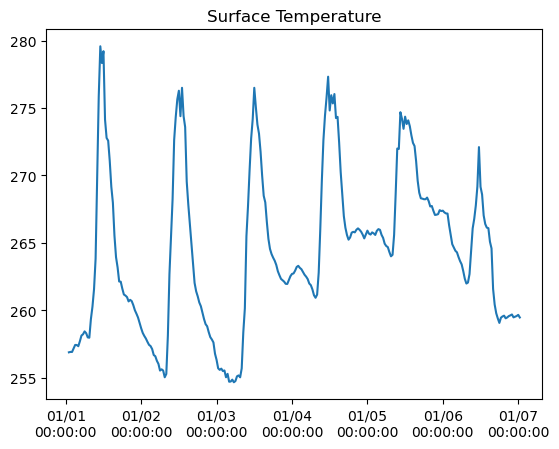

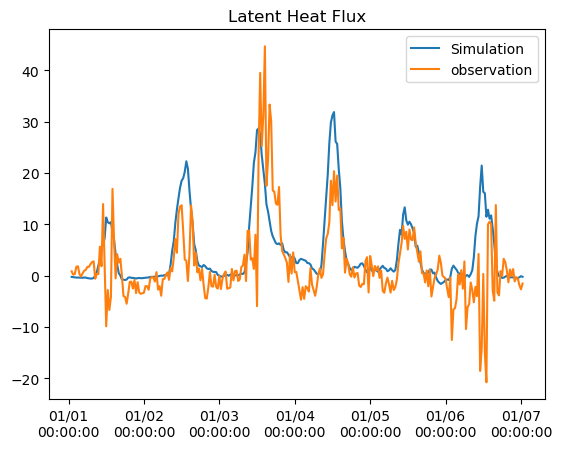

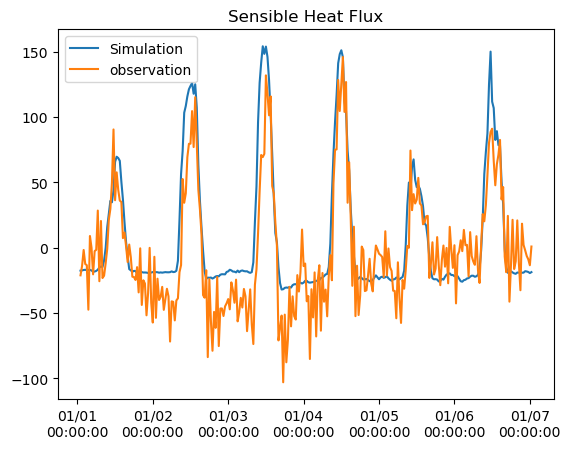

In [282]:
optimize_le_q(min=250,max=350,savename_ts='./png/surface_temp_3.png',savename_le='./png/lE_3.png',savename_h='./png/H_3.png')

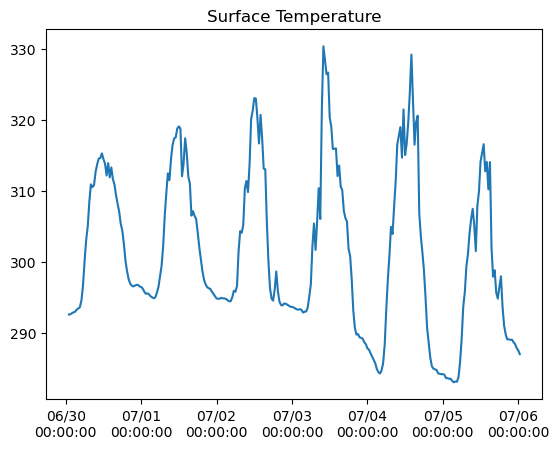

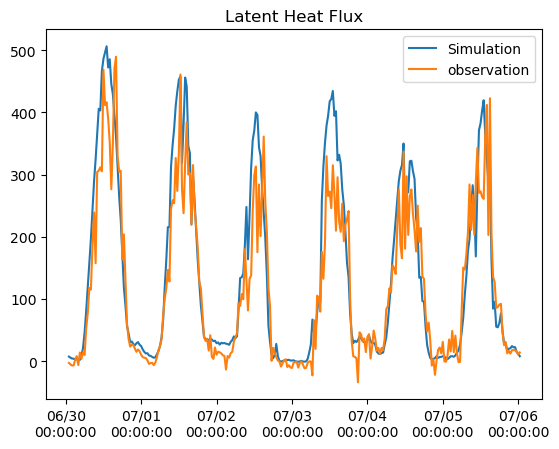

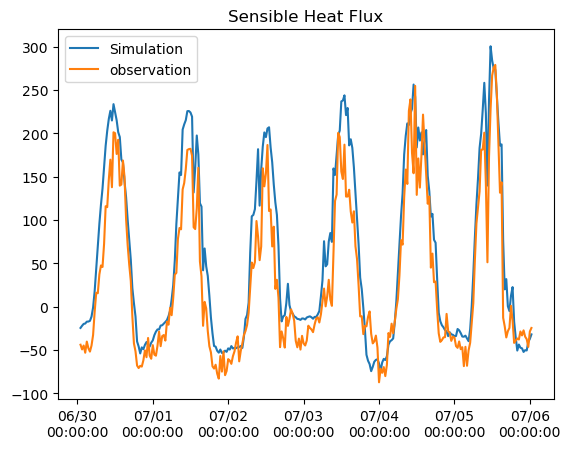

In [290]:
optimize_le_q(min=260,max=350,savename_ts='./png/surface_temp_3_summer.png',savename_le='./png/lE_3_summer.png',savename_h='./png/H_3_summer.png')

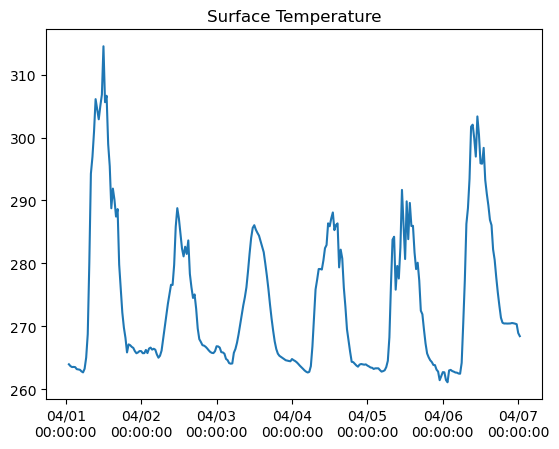

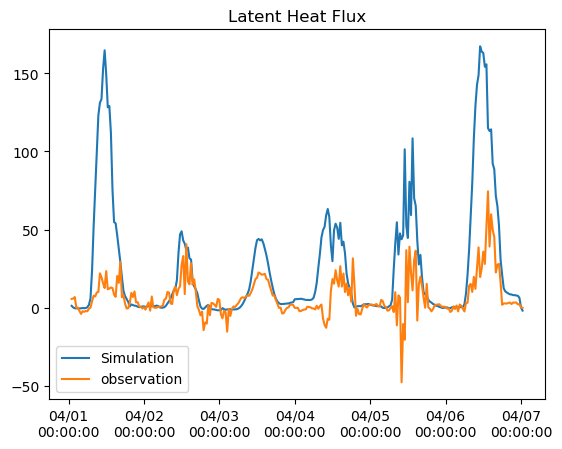

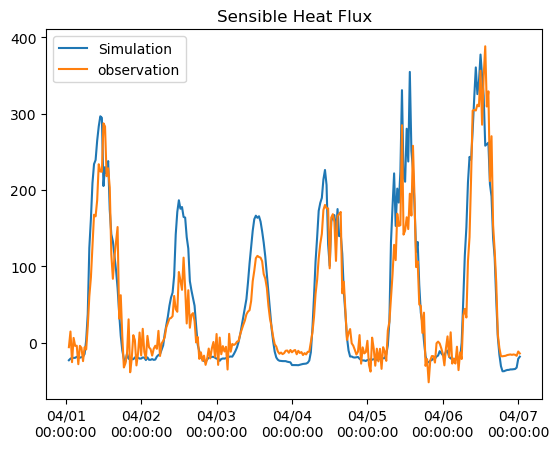

In [292]:
optimize_le_q(min=260,max=350,savename_ts='./png/surface_temp_3_spring.png',savename_le='./png/lE_3_spring.png',savename_h='./png/H_3_spring.png')

## find temprature which satisfy the enegy balance function

In [250]:
def find_ts():
    T_surface = []
    for time in range(len(date)):
        #first guess Ts = Ta + dt
        dt = 12
        ts = [T[time]+dt]
        res = 0;i=0;diff=1
        max_iter = 50
        
        #newton method
        while diff > 10**-6 and i < max_iter:
            energy_prime = derivarate(energy,ts[i],time) #偏微分係数
            f_energy = energy(ts[i],time) #関数の値
            res = ts[i] - energy_prime/f_energy #ニュートン法による漸近
            ts.append(res)
            diff = ts[i+1]-ts[i] #前の値からの改善度
            i+=1
            #print(f"In time={time} loop={i},res = {res}K")
            if res > 300 or res < 240:
                print(f"In time={time} loop={i},res = {res}K")
        T_surface.append(ts[-1])
    return T_surface
        
    

In time=69 loop=49,res = 302.59728064442163K
In time=69 loop=50,res = 302.5383991111871K


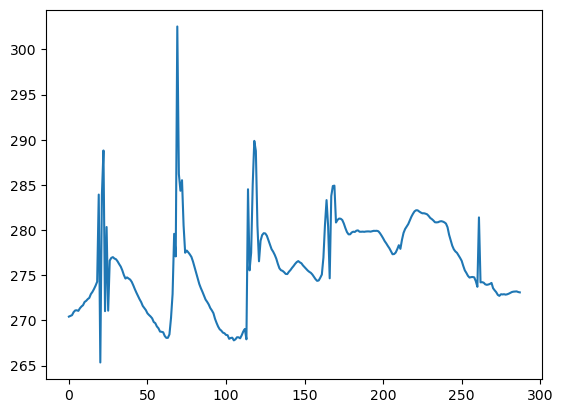

In [251]:
#check T
T_surface = find_ts()
fig,ax = plt.subplots()
ax.plot(T_surface)
plt.show()

## again calculate LE & H

In [205]:
lE,H = np.zeros(len(date)),np.zeros(len(date))
for time in range(len(date)):
    temp = T_surface[time]
    lE[time] = l * wind_func(WIND[time]) * (QS(temp-273.15,PRES[time]/100)-SH[time]) #セ氏に変換
    H[time] = cp * wind_func(WIND[time]) * (temp - T[time])


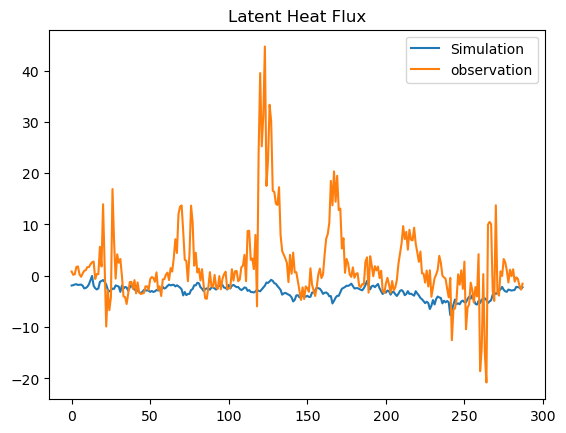

In [206]:
fig,ax = plt.subplots()
ax.plot(lE,label='Simulation')
ax.plot(Qle,label='observation')
ax.set_title('Latent Heat Flux')
ax.legend();plt.show()

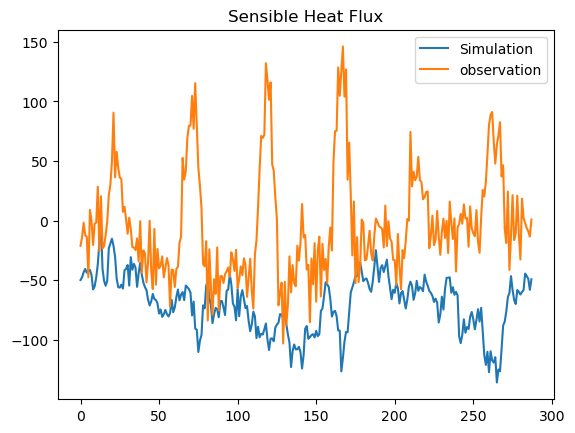

In [207]:
fig,ax = plt.subplots()
ax.plot(H,label='Simulation')
ax.plot(Qh,label='observation')
ax.set_title('Sensible Heat Flux')
ax.legend();plt.show()

## 二分法による解の推定

In [279]:
def bisection_method(func, a, b, tol, max_iter,time):
    """
    二分法を用いて関数の解を求める

    Parameters:
        func (function): 解を求めたい関数
        a (float): 区間の下限
        b (float): 区間の上限
        tol (float): 許容誤差
        max_iter (int): 最大反復回数

    Returns:
        float: 解の近似値
    """
    if func(a,time) * func(b,time) >= 0:
        raise ValueError("関数の値が区間の両端で同符号です。二分法は使用できません。")

    for i in range(max_iter):
        c = (a + b) / 2
        if abs(func(c,time)) < tol:
            return c

        if func(a,time) * func(c,time) < 0:
            b = c
        else:
            a = c

    raise RuntimeError("解が見つかりませんでした。反復回数が上限に達しました。")


def bisection(min,max):
    Ts = np.zeros(len(date))
    for time in range(len(date)):
        #energy(temp,time)
        Ts[time] = bisection_method(energy, min, max, 1e-6, 50,time)
    return Ts

def optimize_le_q(min=250,max=350,savename_ts='./png/surface_temp_3.png',savename_le='./png/lE_3.png',savename_h='./png/H_3.png'):
    
    #calc Ts
    Ts = bisection(min,max)
    #check Ts
    fig,ax = plt.subplots()
    ax.plot(date,Ts,label='Surface Temperature(degC)')
    ax.set_title('Surface Temperature')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M:%S"))
    plt.show();fig.savefig(savename_ts)
    
    #calculate le and H
    lE,H = np.zeros(len(date)),np.zeros(len(date))
    for time in range(len(date)):
        temp = Ts[time]
        lE[time] = l * wind_func(WIND[time]) * (QS(temp-273.15,PRES[time]/100)-SH[time]) #セ氏に変換
        H[time] = cp * wind_func(WIND[time]) * (temp - T[time])

    #latent heat flux
    fig,ax = plt.subplots()
    ax.plot(date,lE,label='Simulation')
    ax.plot(date,Qle,label='observation')
    ax.set_title('Latent Heat Flux')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M:%S"))
    ax.legend();plt.show();fig.savefig(savename_le)

    #sensible heat flux
    fig,ax = plt.subplots()
    ax.plot(date,H,label='Simulation')
    ax.plot(date,Qh,label='observation')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M:%S"))
    ax.set_title('Sensible Heat Flux')
    ax.legend();plt.show();fig.savefig(savename_h)